<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/neqsimreaktoro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of third party libraries in NeqSim process simulations
In this workbook we will give examples of how to use third party tools such as Reaktoro, Refprop, CoolProp, Cantera and ThermoPack in a NeqSim process simulation.

This documentation is part of [Introduction of Gas Processsing using NeqSim and Python](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb).

# Use of Reaktoro as a unit operation in NeqSim process simulation
In the following example we will integrate Reaktoro as an unit operation in a NeqSim process simulation

In [ ]:
!pip install neqsim==2.5.35

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 12.5 MB/s eta 0:00:00


In [ ]:
%%capture
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://repo.anaconda.com/miniconda/Miniconda3-py38_4.12.0-Linux-x86_64.sh")
!conda config --remove channels defaults
!conda config --add channels conda-forge
!conda install reaktoro -y

# Implementing a Reaktoro unit operation in NeqSim

In [ ]:
from neqsim.process.unitop import unitop
from neqsim import jNeqSim
from jpype import JImplements, JOverride
import reaktoro as rkt
import json

class ReaktoroUnitOperation(unitop):
    def __init__(self):
        super().__init__()
        self.serialVersionUID = None
        self.name = ""
        self.inputstream = None
        self.aprops = None
        self.fugacity_co2 = None

    def setInputStream(self, stream):
        self.inputstream = stream

    def calc_reaktoro(self, pressure, temperature , fugacity_co2):
      db = rkt.PhreeqcDatabase("phreeqc.dat")
      solution = rkt.AqueousPhase(rkt.speciate("H O Na Cl C Ca"))
      solution.set(rkt.ActivityModelPhreeqc(db))

      calcite = rkt.MineralPhase("Calcite")

      system = rkt.ChemicalSystem(db, solution, calcite)

      specs = rkt.EquilibriumSpecs(system)
      specs.temperature()
      specs.pressure()
      specs.fugacity("CO2(g)")

      solver = rkt.EquilibriumSolver(specs)

      state = rkt.ChemicalState(system)
      state.temperature(50.0, "celsius")
      state.pressure(10.0, "bar")
      state.set("H2O", 1.0, "kg")
      state.set("Na+", 1.0, "mol")
      state.set("Cl-", 1.0, "mol")
      state.set("Calcite", 10, "g")

      conditions = rkt.EquilibriumConditions(specs)
      conditions.temperature(temperature, "celsius")
      conditions.pressure(pressure, "bar")
      conditions.fugacity("CO2(g)", fugacity_co2, "bar")

      result = solver.solve(state, conditions)
      return rkt.AqueousProps(state)

    @JOverride
    def run(self, uuid):
      self.serialVersionUID = uuid
      print("ReaktoroUnitOperation.run()")
      self.fugacity_co2 = self.inputstream.getFluid().getPhase(0).getFugacity('CO2')
      self.aprops = self.calc_reaktoro(self.inputstream.getPressure('bara'), self.inputstream.getTemperature('C'), self.fugacity_co2)

    @JOverride
    def toJson(self):
      data_dict = {
            "name": self.name,
            "pH": self.aprops.pH()[0],
            "fugacity CO2": self.fugacity_co2
      }
      return json.dumps(data_dict)


# Implement the Reaktoro unit operation in a NeqSim simulation
The unit operation will report the pH of an aqueous phase with some ions in equilibrium with the gas.

In [ ]:
from neqsim.thermo import fluid
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
fluid1.setTemperature(30.0, "C")
fluid1.setPressure(100.0, "bara")
fluid1.addComponent("methane", 0.9)
fluid1.addComponent("CO2", 0.1)
fluid1.setMixingRule(2)

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
stream1.setFlowRate(30000, "kg/hr")

uop = ReaktoroUnitOperation()
uop.setName("Reaktoro Unit Operation")
uop.setInputStream(stream1)

example_process = jNeqSim.processSimulation.processSystem.ProcessSystem()
example_process.add(stream1)
example_process.add(uop)

example_process.run()


In [ ]:
json_report= str(jNeqSim.processSimulation.util.report.Report(example_process).generateJsonReport())
output = json.loads(json_report)
print(output['Reaktoro Unit Operation'])

ReaktoroUnitOperation.run()
{'name': 'Reaktoro Unit Operation', 'pH': 5.520539435475417, 'fugacity CO2': 6.970782669382442}


# Use of CoolProp as a unit operation in NeqSim process simulation
In the following example we will integrate CoolProp as an unit operation in a NeqSim process simulation

http://www.coolprop.org/coolprop/examples.html

In [ ]:
!pip install CoolProp

In [ ]:
from neqsim.process.unitop import unitop
from neqsim import jNeqSim
from jpype import JImplements, JOverride
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
import json

class CoolPropUnitOperation(unitop):
    def __init__(self):
        super().__init__()
        self.serialVersionUID = None
        self.name = ""
        self.inputstream = None
        self.densityCO2 = None
        self.densityCO2_neqsim = None


    def setInputStream(self, stream):
        self.inputstream = stream

    def calc_cool_prop(self):
      return PropsSI('D', 'T', self.inputstream.getTemperature('K'), 'P', self.inputstream.getPressure('Pa'), 'CO2')

    @JOverride
    def run(self, uuid):
      self.serialVersionUID = id
      self.inputstream.getFluid().initPhysicalProperties('Density')
      self.densityCO2 = self.calc_cool_prop()
      self.densityCO2_neqsim = self.inputstream.getFluid().getPhase(0).getDensity('kg/m3')

    @JOverride
    def toJson(self):
      data_dict = {
            "name": self.name,
            "densityCO2_CoolProp": self.densityCO2,
            "densityCO2_NeqSim": self.densityCO2_neqsim
      }
      return json.dumps(data_dict)

In [ ]:
from neqsim.thermo import fluid
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
fluid1.setTemperature(14.3, "C")
fluid1.setPressure(55.0, "bara")
fluid1.addComponent("CO2", 0.1)
fluid1.setMixingRule(2)

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
stream1.setFlowRate(30000, "kg/hr")

uop = CoolPropUnitOperation()
uop.setName("CoolProp Unit Operation")
uop.setInputStream(stream1)

example_process = jNeqSim.processSimulation.processSystem.ProcessSystem()
example_process.add(stream1)
example_process.add(uop)

example_process.run()

In [ ]:
json_report= str(jNeqSim.processSimulation.util.report.Report(example_process).generateJsonReport())
output = json.loads(json_report)
print(output['CoolProp Unit Operation'])

{'name': 'CoolProp Unit Operation', 'densityCO2_CoolProp': 837.1416548396195, 'densityCO2_NeqSim': 742.8594991083878}


# Use of ThermoPack as a unit operation in NeqSim process simulation
In the following example we will integrate ThermoPack as an unit operation in a NeqSim process simulation

https://pypi.org/project/thermopack/

In [ ]:
!pip install thermopack

In [ ]:
from neqsim.process.unitop import unitop
from neqsim import jNeqSim
from jpype import JImplements, JOverride
from thermopack.saftvrmie import saftvrmie
import json

class ThermoPackUnitOperation(unitop):
    def __init__(self):
        super().__init__()
        self.serialVersionUID = None
        self.name = ""
        self.inputstream = None
        self.densityCO2 = None
        self.densityCO2_neqsim = None

    def setInputStream(self, stream):
        self.inputstream = stream

    def calc_thermo_pack_prop(self):
      eos = saftvrmie('C1,CO2')
      T = 300 # Kelvin
      p = 1e5 # Pascal
      x = self.inputstream.getFluid().getzvector() # Molar composition
      vg, = eos.specific_volume(self.inputstream.getTemperature('K'), self.inputstream.getPressure('Pa'), x, eos.TWOPH) # Molar volume of gas phase (NB: Notice the comma)
      return self.inputstream.getFluid().getPhase(0).getMolarMass('kg/mol')/vg

    @JOverride
    def run(self, uuid):
      self.serialVersionUID = uuid
      self.inputstream.getFluid().initPhysicalProperties('Density')
      self.densityCO2 = self.calc_thermo_pack_prop()
      self.densityCO2_neqsim = self.inputstream.getFluid().getPhase(0).getDensity('kg/m3')

    @JOverride
    def toJson(self):
      data_dict = {
            "name": self.name,
            "densityCO2_ThermoPack": self.densityCO2,
            "densityCO2_NeqSim": self.densityCO2_neqsim
      }
      return json.dumps(data_dict)

In [ ]:
from neqsim.thermo import fluid
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
fluid1.setTemperature(14.3, "C")
fluid1.setPressure(65.0, "bara")
fluid1.addComponent("methane", 0.01)
fluid1.addComponent("CO2", 0.99)
fluid1.setMixingRule(2)

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
stream1.setFlowRate(30000, "kg/hr")

uop = ThermoPackUnitOperation()
uop.setName("ThermoPack Unit Operation")
uop.setInputStream(stream1)

example_process = jNeqSim.processSimulation.processSystem.ProcessSystem()
example_process.add(stream1)
example_process.add(uop)

example_process.run()

In [ ]:
json_report= str(jNeqSim.processSimulation.util.report.Report(example_process).generateJsonReport())
output = json.loads(json_report)
print(output['ThermoPack Unit Operation'])

{'name': 'ThermoPack Unit Operation', 'densityCO2_ThermoPack': 856.638171127874, 'densityCO2_NeqSim': 751.3317350536282}


**Use of Cantera as a unit operation in NeqSim process simulation**

Cantera is an open-source collection of object-oriented software tools for problems involving chemical kinetics, thermodynamics, and transport processes.

*   Evaluate thermodynamic and transport properties of mixtures
*   Evaluate species chemical production rates
*   Compute chemical equilibrium
*   Evaluate species chemical production rates
*   Conduct kinetics simulations with large reaction mechanisms
*   Simulate one-dimensional flames
*   Conduct reaction path analysis
*   Create process simulations using networks of stirred reactors
*   Model non-ideal fluids

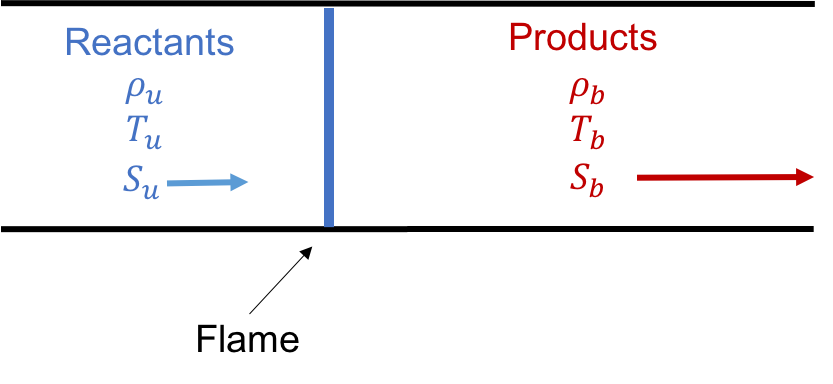

https://github.com/Cantera/cantera-jupyter/blob/main/flames/flame_speed_with_convergence_analysis.ipynb

In [ ]:
%%capture
!pip install neqsim==2.5.35
!pip install cantera

In [ ]:
from neqsim.process.unitop import unitop
from neqsim import jNeqSim
from jpype import JImplements, JOverride
import cantera as ct
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [ ]:
class CanteraUnitOperation(unitop):
    def __init__(self):
        super().__init__()
        self.serialVersionUID = None
        self.name = ""
        self.inputstream = None
        self.oxidizerStream = None
        self.flameSpeed = None
        self.width = 0.015 #m
        self.flame_speed = None
        self.flame = None

        # Import plotting modules and define plotting preference
        %config InlineBackend.figure_formats = ["svg"]
        %matplotlib inline

        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["figure.dpi"] = 120

        # Get the best of both ggplot and seaborn
        plt.style.use("ggplot")
        plt.style.use("seaborn-v0_8-deep")

        plt.rcParams["figure.autolayout"] = True

    def setInputStream(self, stream):
        self.inputstream = stream

    def setFuelStream(self, stream):
        self.inputstream = stream

    def setOxidizerStream(self, stream):
        self.oxidizerStream = stream

    def setWidth(self, width):
        self.width = width

    def getFlameSpeed(self):
      return self.flameSpeed

    def plotFlame(self):
      plt.figure()

      plt.plot(self.flame.grid * 100, self.flame.T, "-o")
      plt.xlabel("Distance (cm)")
      plt.ylabel("Temperature (K)");
      plt.show()

    def calc_flame(self):
      # Inlet Temperature in Kelvin and Inlet Pressure in Pascals
      # In this case we are setting the inlet T and P to room temperature conditions
      To = self.inputstream.getTemperature()
      Po = self.inputstream.getPressure("Pa")
      fuel_oxidizer_ratio = self.inputstream.getFlowRate("mole/sec")/self.oxidizerStream.getFlowRate("mole/sec")

      # Define the gas-mixutre and kinetics
      # In this case, we are choosing a GRI3.0 gas kinetics
      gas = ct.Solution("gri30.yaml")

      fuel_composition = self.get_composition(self.inputstream)
      oxidizer_composition = self.get_composition(self.oxidizerStream)

      # Create a stoichiometric CH4/Air premixed mixture
      gas.set_equivalence_ratio(fuel_oxidizer_ratio, fuel_composition, oxidizer_composition, basis='mole')


      gas.TP = To, Po

      # Create the flame object
      self.flame = ct.FreeFlame(gas, width=self.width)

      # Define tolerances for the solver
      self.flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

      # Define logging level
      loglevel = 0

      self.flame.solve(loglevel=loglevel, auto=True)
      self.flameSpeed = self.flame.velocity[0]

      #return rkt.AqueousProps(state)

    def get_composition(self, stream):
      composition = ""
      components_list = [stream.getFluid().getComponent(i).getName() for i in range(stream.getFluid().getNumberOfComponents())]
      for component in components_list:
        mole_fraction = stream.getFluid().getComponent(component).getz()
        if component == "methane":
          component = "CH4"
        elif component == "ethane":
          component = "C2H6"
        elif component == "propane":
          component = "C3H8"
        elif component == "nitrogen":
          component = "N2"
        elif component == "oxygen":
          component = "O2"

        composition += str(component) + ":"+ str(mole_fraction) + ","
      return composition[:-1]

    @JOverride
    def run(self, uuid):
      self.serialVersionUID = uuid
      self.calc_flame()

    @JOverride
    def toJson(self):
      data_dict = {
            "name": self.name,
            "flame_speed": self.flameSpeed
      }
      return json.dumps(data_dict)

Flame Speed is: 7.35 cm/s


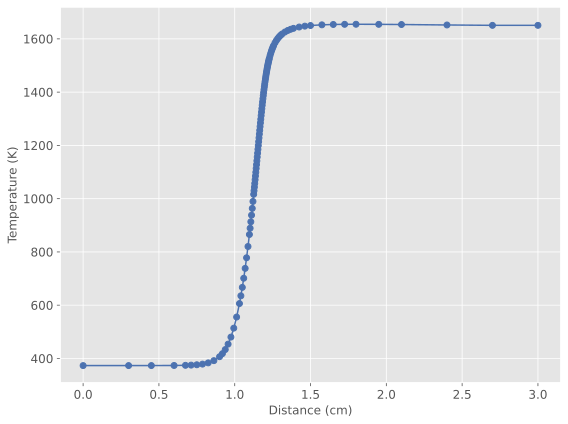

In [ ]:
temperature = 100 #C
pressure = 1.01325 #bara

#Fuel
fuel_rate = 10 #kg/hr
methane = 0.5 #mol fraction
ethane = 0.25
propane = 0.24
nitrogen = 0.005
CO2 = 0.005
O2 = 0.0
#oxidizer
oxidizer_rate = 5 #kg/hr
o2_oxidizer = 0.21 #mole fraction
n2_oxidizer = 0.79
#burner
burner_width = 0.015 #m

from neqsim.thermo import fluid
#Fuel
fluid1 = fluid("srk")  # create a fluid using the SRK-EoS
fluid1.setTemperature(temperature, "C")
fluid1.setPressure(pressure, "bara")
fluid1.addComponent("methane", methane)
fluid1.addComponent("ethane", ethane)
fluid1.addComponent("propane", propane)
fluid1.addComponent("nitrogen", nitrogen)
fluid1.addComponent("CO2", CO2)
fluid1.addComponent("O2", O2)
fluid1.setMixingRule(2)

stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid1)
stream1.setFlowRate(fuel_rate, "kg/hr")

components_list = [stream1.getFluid().getComponent(i).getName() for i in range(stream1.getFluid().getNumberOfComponents())]

#Oxidizer
fluid2 = fluid1.clone()
fluid2.setMolarComposition(        [
            n2_oxidizer if component == "nitrogen" else o2_oxidizer if component == "oxygen" else 0
            for component in components_list
        ])

stream2 = jNeqSim.processSimulation.processEquipment.stream.Stream(fluid2)
stream2.setFlowRate(oxidizer_rate, "kg/hr")

burner = CanteraUnitOperation()
burner.setName("Adiabatic Burner")
burner.setFuelStream(stream1)
burner.setOxidizerStream(stream2)
burner.setWidth(burner_width)

example_process = jNeqSim.processSimulation.processSystem.ProcessSystem()
example_process.add(stream1)
example_process.add(stream2)
example_process.add(burner)
example_process.run()

flame_speed = burner.getFlameSpeed()
print(f"Flame Speed is: {flame_speed * 100:.2f} cm/s")
burner.plotFlame()

#Use of the Fluids package in a NeqSim process simulation


In t his section we will use calculations of an orifice pressure drop (see documentation):


https://fluids.readthedocs.io/fluids.flow_meter.html

In [ ]:
%%capture
!pip install fluids

In [ ]:
from neqsim.process.unitop import unitop
from neqsim import jNeqSim
from jpype import JImplements, JOverride
import fluids
import json

class Orifice(unitop):
    def __init__(self, name):
        super().__init__()
        self.serialVersionUID = None
        self.name = name
        self.inputstream = None
        self.outputstream = None
        self.dp = None
        self.diameter = None
        self.diameter_outer = None
        self.C = None

    def setInputStream(self, stream):
        self.outputstream = stream.clone()
        self.inputstream = stream

    def getOutputStream(self):
        return self.outputstream

    def setOrificeParameters(self, diameter, diameter_outer, C):
        self.diameter = diameter
        self.diameter_outer = diameter_outer
        self.C = C

    def calc_dp(self):
        try:
            self.dp = fluids.flow_meter.dP_orifice(
                D=self.diameter,
                Do=self.diameter_outer,
                P1=self.inputstream.getPressure('Pa'),
                P2=self.inputstream.getPressure('Pa') * 0.95,
                C=self.C
            ) / 1e5
        except Exception as e:
            print(f"An error occurred in calc_dp: {e}")
        return self.dp

    @JOverride
    def run(self, uuid):
        out_fluid = self.inputstream.getFluid().clone()
        out_fluid.setPressure(self.inputstream.getPressure('bara') - self.calc_dp(), 'bara')
        self.outputstream.setFluid(out_fluid)
        self.outputstream.run()

    @JOverride
    def toJson(self):
        data_dict = {
            "name": self.name,
            "diameter": self.diameter,
            "diameter_outer": self.diameter_outer,
            "C": self.C,
            "dP": self.dp
        }
        return json.dumps(data_dict)

In [ ]:
from neqsim import jNeqSim
from neqsim.thermo.thermoTools import fluid

# Create a fluid with the SRK (Soave-Redlich-Kwong) equation of state
fluid1 = fluid("srk")
fluid1.setTemperature(30.0, "C")
fluid1.setPressure(10.0, "bara")
fluid1.addComponent("methane", 1.0, "kg/sec")
fluid1.setMixingRule(2)

# Create a stream with the fluid
stream1 = jNeqSim.processSimulation.processEquipment.stream.Stream("stream 1", fluid1)
stream1.setFlowRate(3000, "kg/hr")

# Define and set up the orifice unit operation
orif1 = Orifice(name="orifice 1")
orif1.setName("orifice 1")
orif1.setInputStream(stream1)
orif1.setOrificeParameters(diameter=0.07366, diameter_outer=0.05, C=0.61)  # Corrected parameter spelling

# Define the output stream after the orifice
stream2 = jNeqSim.processSimulation.processEquipment.stream.Stream("stream2", orif1.getOutputStream())

# Set up and run the process system
oilprocess = jNeqSim.processSimulation.processSystem.ProcessSystem()
oilprocess.add(stream1)
oilprocess.add(orif1)
oilprocess.add(stream2)

oilprocess.run()

# Output the pressure after the orifice
print('Pressure out of orifice:', stream2.getPressure('bara'), 'bara')

Pressure out of orifice: 9.731895927508736 bara
